In [1]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import os
import datetime as dt
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from decimal import *

import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns

from numpy.linalg import inv

from cvxpy import *

from IPython.core.debugger import Tracer

In [2]:
root_dir = '/Users/yma/Dropbox/MFE230K_Asset/Dynamic_Factor_Timing_Project'

In [3]:
def align_data(df_assets, df_factors):
    
    # concatenate factors and assets data
    df_all = pd.concat([df_assets, df_factors], axis = 1)
    df_all.dropna(inplace = True)

    N_factors = df_factors.shape[1]
    N_assets = df_assets.shape[1]

    if (N_assets + N_factors) != df_all.shape[1]:
        print('error!')
    
    df_assets = df_all.iloc[:, :N_assets]
    df_factors = df_all.iloc[:, N_assets:]
    
    return df_assets, df_factors

In [12]:
# read factor data
df_factors = pd.read_csv(root_dir + '/data' + \
                        '/Monthly_Factors_No_Liq.csv')

df_factors.set_index('Date', inplace = True)
df_factors.index = pd.to_datetime(df_factors.index)
df_factors.index = df_factors.index.map(lambda x:x.strftime('%Y-%m'))


# read the assets
df_assets  = pd.read_csv(root_dir + '/data/asset_return.csv')
df_assets = df_assets.rename(columns = {df_assets.columns[0]:'Date'})
df_assets.set_index('Date', inplace = True)
df_assets.sort_index(inplace = True)

df_assets, df_factors = align_data(df_assets, df_factors)

df_assets = df_assets.subtract(df_factors['RF'], axis = 0)

# read trading cost
df_cost = pd.read_csv(root_dir + '/data/asset_cost.csv', index_col = 0)

In [6]:
del df_factors['BXM Volatility']
df_RF = df_factors['RF']
del df_factors['RF']

In [7]:
# do regression
def factor_decomposition(df_assets, df_factors):
    df_pvalues = pd.DataFrame(index = df_factors.columns, columns = df_assets.columns)
    #df_betas =  pd.DataFrame(index = df_factors.columns, columns = df_assets.columns)
    df_betas = pd.DataFrame(columns = df_assets.columns)
    
    for asset in df_assets.columns:
        Y = df_assets[asset]
        X = df_factors
        X = sm.add_constant(X)

        model = sm.OLS(Y, X)
        results = model.fit()

        df_betas[asset] = results.params
        df_pvalues[asset] = results.pvalues
        df_pvalues.loc['R2(%)', asset] = results.rsquared * 100
    
    return df_betas.iloc[1:,:], df_betas.iloc[0,:], df_pvalues

# All data

In [8]:
# use all data
betas, consts, pvalues = factor_decomposition(df_assets, df_factors)

In [20]:
betas

,Equity_russel_3000,Equity_global_MSCI_ACWI,Bond_US_Barclay_ETF,Bond_US_Barclay_TIPS,Bond_US_HighYield_bond_Index,IYR,FOF_Fund of Fund,PE
Momentum,-0.089298,-2.661934,1.723564,-0.432067,1.864474,4.291800,0.702172,0.787072
BXM Volatility,1.220612,2.433861,-0.320593,0.948169,-0.088276,1.303554,-0.359681,-0.232658
Mkt-RF,0.812045,2.199300,-0.492012,0.810953,-0.167531,1.095730,-0.061354,-1.404456
SMB,0.047758,-4.697237,3.298516,0.120089,4.463408,10.273439,-0.014153,2.910724
HML,1.548040,4.712708,2.104494,4.970757,2.330165,6.432868,-1.756555,2.600363
RF,-1111.993674,-3139.894687,482.640902,-1194.593549,94.466220,-1805.766958,604.386511,-1383.675120
HY Credit Spread,0.032074,-0.142191,0.276289,0.197480,0.110553,1.025536,-0.143120,0.070965
IG Credit Spread,-0.252462,0.009263,-0.506803,-0.345685,-0.666578,-1.903880,0.165149,0.096762
VIX,-0.105507,-0.141449,-0.016165,-0.049003,-0.001698,-0.156900,-0.019367,-0.102763


In [21]:
consts

Equity_russel_3000             -5.580182e-08
Equity_global_MSCI_ACWI        -3.280144e-07
Bond_US_Barclay_ETF             3.892241e-07
Bond_US_Barclay_TIPS            2.027841e-07
Bond_US_HighYield_bond_Index    3.996706e-07
IYR                             6.173575e-07
FOF_Fund of Fund               -2.363555e-07
PE                              3.732910e-08
Name: const, dtype: float64

# Start here

In [9]:
def mean_variance_model_TC(asset_alpha, asset_cov, df_cost, w0, lam = 10000):
    N_asset = asset_cov.shape[0]
    w = Variable(N_asset)
    gamma = Parameter(sign = 'positive')
    ret = np.array(asset_alpha).T * w
    risk = quad_form(w, np.array(asset_cov))
    trading_cost = np.array(df_cost.loc['trading',:])*abs(w - np.array(w0))
    holding_cost = np.array(df_cost.loc['holding',:])*w / 12
    
    prob = Problem(Maximize(ret - gamma * risk - trading_cost - holding_cost),\
                   [sum_entries(w) == 1, w >= 0])
                   
    gamma.value = lam
    prob.solve()
    
    df_sol = pd.Series(data = np.array(w.value).flatten(), index = asset_alpha.index)
    return df_sol

In [14]:
def portfolio(df_assets, df_weight, df_cost, df_RF):
    '''
    asset return for each period, and weights
    '''
    # transaction cost for each month
    # first line should be cash holding
    
    pf_value = pd.Series(index = df_weight.index)
    pf_value.iloc[0] = 1

    for i in np.arange(1, df_weight.shape[0]):
        month = df_weight.index[i]
      
        trading_cost = np.abs(df_weight.iloc[i,:] - df_weight.iloc[i-1,:]).dot(\
                                df_cost.loc['trading', :]) * pf_value.iloc[i-1]
        
        pf_value.iloc[i] = pf_value.iloc[i-1] * \
            df_weight.iloc[i,:].dot(1 + df_assets.loc[month,:] + df_RF.loc[month]\
                                    - df_cost.loc['holding',:]/12) - \
            trading_cost
    
    return pf_value

In [15]:
# covariance prediction
alpha_ = 0.5
#alpha_ = 0.0

df_weight = pd.DataFrame(data = np.zeros( df_assets.shape ), index = df_assets.index, columns = df_assets.columns)
N_skip = 12

for month in df_assets.index:
    
    ind = np.where(df_assets.index == month)[0][0]
    if ind < N_skip:
        continue

    # prediction on current month
    # use previous data
    df_prev_factor = df_factors.iloc[:ind,:]
    df_prev_asset = df_assets.iloc[:ind, :]
    
    n = df_prev_factor.shape[0]
    weights = (1 - alpha_) * alpha_** (n - np.arange(1, n+1))
    weights = weights / np.sum(weights)
    
    df_prev_factor = df_prev_factor.multiply(weights, axis = 0)
    df_prev_asset = df_prev_asset.multiply(weights, axis = 0)
    
    
    # prediction of factor alpha
    factor_alpha = df_prev_factor.mean()
    
    # covariance matrix of factors
    factor_cov = df_prev_factor.cov()
    
    # beta
    betas, consts, pvalues = factor_decomposition(df_prev_asset, df_prev_factor)
    
    # covariance between assets
    asset_alpha = betas.transpose().dot(factor_alpha) + consts
    asset_cov = betas.transpose().dot(factor_cov).dot(betas)
    
    
    #asset_alpha = df_prev_asset.mean()
    #asset_cov = df_prev_asset.cov()
    
    # optimization models
    #df_weight.loc[month,:] = 1/df_weight.shape[1]
    df_weight.loc[month, : ] = mean_variance_model_TC(asset_alpha, asset_cov, df_cost, \
                                                      df_weight.iloc[ind,:], 100)
    
df_weight = df_weight.iloc[N_skip-1:, :]   
df_weight.iloc[0, :] = 0
pf = portfolio(df_assets.astype(float), df_weight.astype(float), df_cost, df_RF)

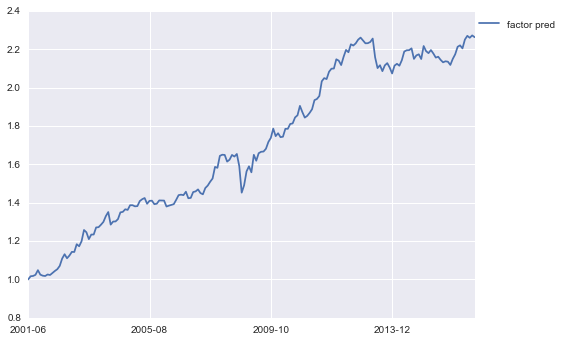

In [18]:
pf.plot(label = 'factor pred')
plt.legend(bbox_to_anchor=(1.2, 1))